In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import os 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pickle
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2M
import numpy as np
import gc


2024-04-04 23:26:13.138022: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 23:26:13.669524: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

mean_columns = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']
FEATURE_COLS = test_df.columns[1:-1].tolist()

train_df.info()
train_df.head()
train_df.describe()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55489 entries, 0 to 55488
Columns: 176 entries, id to X3112_sd
dtypes: float64(54), int64(122)
memory usage: 74.5 MB


,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X18_mean,X26_mean,X50_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd
count,5.548900e+04,55489.000000,55489.000000,55489.000000,55489.000000,55489.000000,55489.000000,55489.000000,55489.000000,55489.000000,...,5.548900e+04,5.548900e+04,55489.000000,5.548900e+04,39148.000000,39148.000000,39148.000000,39148.000000,39148.000000,39148.000000
mean,1.714553e+08,14.577142,1058.710939,138.164359,56.727213,518.711405,25.227185,116.895673,140.259205,128.187695,...,1.969902e+04,3.459399e+03,13.528574,3.975552e+05,0.007833,1.073573,16.003476,110.733150,0.075108,453.017146
std,4.087868e+07,7.584290,768.992166,136.409312,31.692061,316.618440,9.151237,17.607857,15.075214,16.030602,...,2.309747e+06,2.471919e+05,1356.480785,9.152463e+07,0.012046,4.098486,881.605417,8361.855750,0.159520,4196.228211
min,2.637500e+04,-13.731130,0.000000,0.000000,0.000000,9.877081,7.658674,29.000000,46.000000,42.000000,...,2.330000e-08,5.500000e-07,0.000097,7.690000e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.658614e+08,9.247916,528.315552,53.000000,29.685472,300.478760,18.800001,106.000000,131.000000,118.000000,...,3.102831e-01,5.613414e-01,1.173489,2.552815e+02,0.003292,0.174866,0.029985,0.042226,0.017207,17.259899
50%,1.915103e+08,15.536692,853.776184,95.500000,50.196312,446.522308,23.681778,118.000000,142.000000,129.000000,...,7.156651e-01,2.519985e+00,1.480060,7.244318e+02,0.004996,0.357821,0.095136,0.238664,0.033162,63.322952
75%,1.951001e+08,20.238457,1352.000000,181.485718,80.811249,690.003845,30.399998,130.000000,150.000000,139.000000,...,3.586311e+00,1.491886e+01,1.926343,2.148630e+03,0.007774,1.092862,0.330147,1.516574,0.082851,226.990400
max,1.967668e+08,30.294445,8392.463867,2448.964355,169.582291,2025.894653,63.657616,194.000000,192.000000,201.000000,...,2.720494e+08,3.106555e+07,159759.897700,2.155911e+10,0.284052,515.672017,63535.386846,739701.798818,9.729029,387491.201058


In [3]:
sd_columns = [col for col in train_df.columns if col.endswith('_sd')]
train_df.drop(columns=sd_columns, inplace=True)


In [4]:

train_images_path = './data/train_images/'
test_images_path = './data/test_images/'    

train_df['image_path'] = train_df['id'].apply(lambda x: os.path.join(train_images_path, f'{x}.jpeg'))
test_df['image_path'] = test_df['id'].apply(lambda x: os.path.join(test_images_path, f'{x}.jpeg'))

train_df.head()


,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,VOD_X_1997_2018_multiyear_mean_m10,VOD_X_1997_2018_multiyear_mean_m11,VOD_X_1997_2018_multiyear_mean_m12,X4_mean,X11_mean,X18_mean,X26_mean,X50_mean,X3112_mean,image_path
0,192027691,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,0.472432,0.448272,0.403038,0.401753,11.758108,0.117484,1.243779,1.849375,50.216034,./data/train_images/192027691.jpeg
1,195542235,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,0.279112,0.294724,0.311158,0.480334,15.748846,0.389315,0.642940,1.353468,574.098472,./data/train_images/195542235.jpeg
2,196639184,14.254504,902.071411,49.642857,17.873655,387.977753,22.807142,107,133,119,...,0.455066,0.458448,0.455440,0.796917,5.291251,8.552908,0.395241,2.343153,1130.096731,./data/train_images/196639184.jpeg
3,195728812,18.680834,1473.933350,163.100006,45.009758,381.053986,20.436666,120,131,125,...,0.350208,0.349995,0.348838,0.525236,9.568305,1.083629,0.154200,1.155308,1042.686546,./data/train_images/195728812.jpeg
4,195251545,0.673204,530.088867,50.857777,38.230709,1323.526855,45.891998,91,146,120,...,0.488996,0.457526,0.448166,0.411821,14.528877,0.657585,10.919966,2.246226,2386.467180,./data/train_images/195251545.jpeg


In [5]:



def plot_data(df, columns_names):
    plt.figure(figsize=(15, 3))

    # Setting up a grid of plots with 2 columns
    n_cols = 6
    n_rows = len(columns_names) // n_cols + (len(columns_names) % n_cols > 0)

    for i, col in enumerate(columns_names):
        plt.subplot(n_rows, n_cols, i+1)
        sns.kdeplot(df[col], bw_adjust=0.5, fill=False, color='blue')
        plt.title(f'Distribution of {col}')
        plt.xlabel('Value')
        plt.ylabel('Density')

    plt.tight_layout()
    plt.show()
    


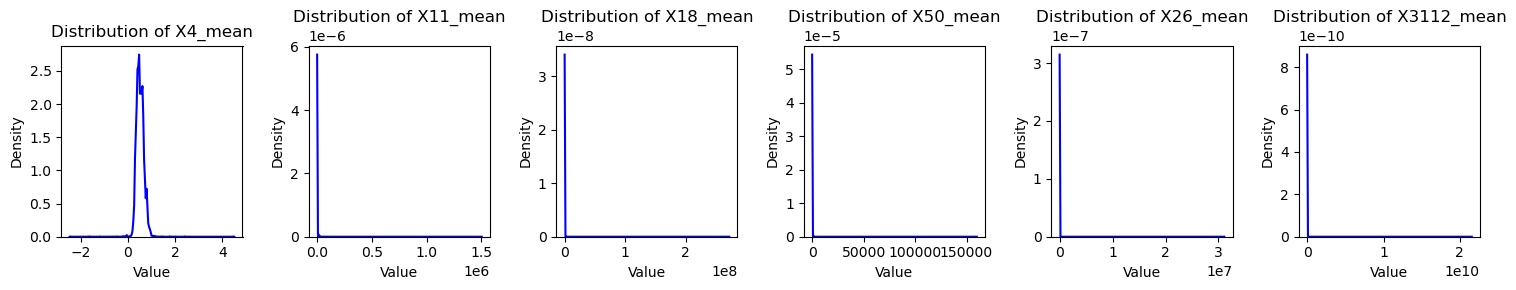

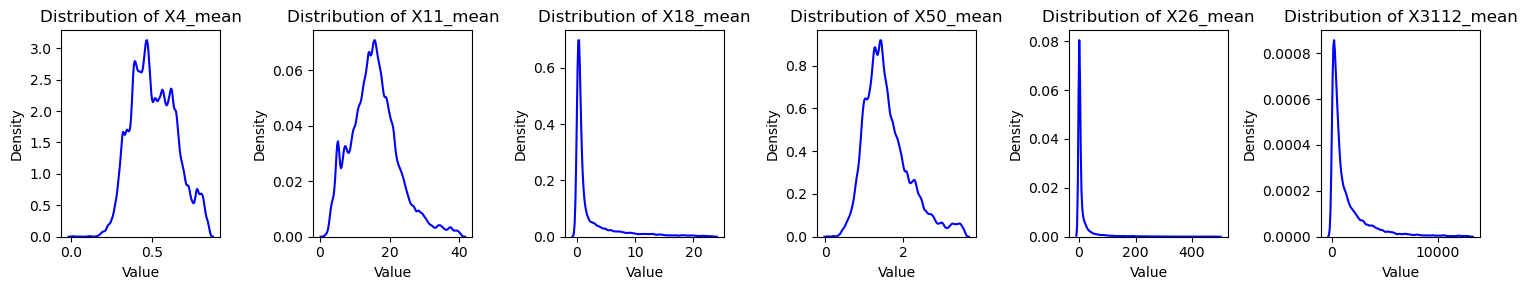

In [6]:
plot_data(train_df, mean_columns)

for column in mean_columns:
    upper_quantile = train_df[column].quantile(0.98)  
    train_df = train_df[(train_df[column] < upper_quantile)]
    train_df = train_df[(train_df[column] > 0)]    

plot_data(train_df, mean_columns)

In [7]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i, trait in enumerate(mean_columns):

    # Determine the bin edges dynamically based on the distribution of traits
    bin_edges = np.percentile(train_df[trait], np.linspace(0, 100, 5 + 1))
    train_df[f"bin_{i}"] = np.digitize(train_df[trait], bin_edges)

# Concatenate the bins into a final bin
train_df["final_bin"] = (
    train_df[[f"bin_{i}" for i in range(len(mean_columns))]]
    .astype(str)
    .agg("".join, axis=1)
)

# Perform the stratified split using final bin
train_df = train_df.reset_index(drop=True)
for fold, (train_idx, valid_idx) in enumerate(skf.split(train_df, train_df["final_bin"])):
    train_df.loc[valid_idx, "fold"] = fold



/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [8]:
scaler = StandardScaler()

train_df[mean_columns] = scaler.fit_transform(train_df[mean_columns])

with open('./data/scaler_targets_train.pickle', 'wb') as f:
    pickle.dump(scaler, f)



# plot_data(train_df, mean_columns)

# with open('./data/scaler_train.pickle', 'rb') as f:
#     loaded_scaler = pickle.load(f)    
#     train_df[mean_columns] = loaded_scaler.inverse_transform(train_df[mean_columns])

# plot_data(train_df)





In [9]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

batch_size = 64

os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

base_model = EfficientNetV2M(weights='imagenet', include_top=False, pooling='avg')
base_model.trainable = False

def load_and_preprocess_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (480, 480))
    return img


def extract_features_batch(image_paths):
    img_batch = np.stack([load_and_preprocess_image(img_path) for img_path in image_paths])
    features = base_model.predict(img_batch)        
    return features

image_paths = train_df['image_path'].values

features_list = []
j = 0
for i in range(0, len(image_paths), batch_size):
    batch_paths = image_paths[i:i+batch_size]
    batch_features = extract_features_batch(batch_paths)
    features_list.append(batch_features)
    j += 1
    if j % 30 == 0:
        tf.keras.backend.clear_session()
        gc.collect()
        print(f'Clearing session')

all_features = np.vstack(features_list)
train_df['features'] = list(all_features)




INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080, compute capability 8.6


2024-04-04 23:26:19.875322: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-04 23:26:19.997856: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-04 23:26:19.997939: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-04 23:26:19.998239: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-04 23:26:20.016655: I tensorflow/compile

2/2 [==============================] - 0s 285ms/step
Clearing session
2/2 [==============================] - 1s 346ms/step
Clearing session
2/2 [==============================] - 0s 284ms/step
Clearing session
2/2 [==============================] - 0s 287ms/step
Clearing session
2/2 [==============================] - 0s 282ms/step
Clearing session
2/2 [==============================] - 0s 284ms/step
Clearing session
2/2 [==============================] - 0s 278ms/step
Clearing session
2/2 [==============================] - 0s 279ms/step
Clearing session
2/2 [==============================] - 0s 275ms/step
Clearing session
2/2 [==============================] - 0s 275ms/step
Clearing session
2/2 [==============================] - 0s 276ms/step
Clearing session
2/2 [==============================] - 0s 279ms/step
Clearing session
2/2 [==============================] - 0s 287ms/step
Clearing session
2/2 [==============================] - 0s 285ms/step
Clearing session
2/2 [===============

In [10]:
print(train_df.head(10))
print(train_df.describe())
print(train_df.info())

          id  WORLDCLIM_BIO1_annual_mean_temperature  \
0  192027691                               12.235703   
1  195542235                               17.270555   
2  196639184                               14.254504   
3  195728812                               18.680834   
4  195251545                                0.673204   
5  195733955                               12.062123   
6  193133748                                0.271833   
7  195910523                               13.004167   
8  194078966                               16.890060   
9  193113312                               16.151112   

   WORLDCLIM_BIO12_annual_precipitation  \
0                            374.466675   
1                             90.239998   
2                            902.071411   
3                           1473.933350   
4                            530.088867   
5                           1982.033325   
6                            768.048889   
7                           1026.000000

In [11]:
import pickle

# Specify the file path to save the pickle file
pickle_file_path = './data/train_df.pickle'

# Save the train_df dataframe as a pickle file
with open(pickle_file_path, 'wb') as f:
    pickle.dump(train_df, f)


# # Load the train_df dataframe from the pickle file
# with open(pickle_file_path, 'rb') as f:
#     train_df = pickle.load(f)
    


In [12]:
print(train_df['fold'].value_counts())

scaler = StandardScaler()

sample_df = train_df.copy()
train_df = sample_df[sample_df.fold != 3]
valid_df = sample_df[sample_df.fold == 3]
print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")


train_df[FEATURE_COLS] = scaler.fit_transform(train_df[FEATURE_COLS].values)
valid_df[FEATURE_COLS] = scaler.transform(valid_df[FEATURE_COLS].values)

with open('./data/scaler_tabufeatures_train.pickle', 'wb') as f:
    pickle.dump(scaler, f)


fold
1.0    9802
2.0    9802
3.0    9802
0.0    9802
4.0    9801
Name: count, dtype: int64
# Num Train: 39207 | Num Valid: 9802


/tmp/ipykernel_10579/2236561408.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[FEATURE_COLS] = scaler.fit_transform(train_df[FEATURE_COLS].values)
/tmp/ipykernel_10579/2236561408.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df[FEATURE_COLS] = scaler.transform(valid_df[FEATURE_COLS].values)


In [13]:
X_train_tab = train_df[FEATURE_COLS].values
X_train_feat = np.stack(train_df['features'].values)
y_train = train_df[mean_columns].values

X_valid_tab = valid_df[FEATURE_COLS].values 
X_valid_feat = np.stack(valid_df['features'].values)
y_valid = valid_df[mean_columns].values

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from optuna.integration import TFKerasPruningCallback
import optuna
from keras import regularizers, layers, optimizers, initializers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from datetime import timedelta
import time
import os


tf.keras.mixed_precision.set_global_policy('mixed_float16')
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

def r2_score(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred), axis=0)
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true, axis=0)), axis=0)
    r2 = 1 - ss_res/(ss_tot + tf.keras.backend.epsilon())
    r2 = tf.where(tf.math.is_nan(r2), tf.zeros_like(r2), r2)  # Korvaa NaN-arvot nollilla
    return tf.reduce_mean(tf.maximum(r2, 0.0)) 


def create_model(trial):

    image_features_input = Input(shape=(X_train_feat.shape[1],), name='image_features_input')
    tabular_data_input = Input(shape=(X_train_tab.shape[1],), name='tabular_data_input')

    img_num_layers = trial.suggest_int('Imgage layers', 1, 3)
    max_img_units = 1024
    img_dense = image_features_input
    
    image_init = trial.suggest_categorical(f'Img_init', choices = ['glorot_uniform', 'he_normal', 'he_uniform', 'lecun_normal', 'lecun_uniform', 'zeros', 'ones', 'random_normal', 'random_uniform'])
    for i in range(img_num_layers):

        
        num_img_units = trial.suggest_int(f'Num_img_{i}', 32, max_img_units)
        activation_img = trial.suggest_categorical(f'Act_img_{i}', choices = ['relu', 'tanh', 'selu', 'LeakyReLU', 'swish', 'elu'])
        drop_img = trial.suggest_float(f'Drop_img_{i}', 0.2, 0.7, step=0.1)
        batch_norm_img = trial.suggest_categorical(f'Img_BatchN_{i}', choices = [True, False])

        img_dense = Dense(num_img_units, activation=activation_img, kernel_initializer = image_init)(img_dense)
        if batch_norm_img:
            img_dense = layers.BatchNormalization()(img_dense)
        img_dense = Dropout(drop_img)(img_dense)

        max_img_units = min(max_img_units, num_img_units)


    tab_num_layers = trial.suggest_int('Tabular layers', 1, 3)
    max_tab_units = 1024   
    tab_dense = tabular_data_input
    tab_init = trial.suggest_categorical(f'Tab_init', choices = ['glorot_uniform', 'he_normal', 'he_uniform', 'lecun_normal', 'lecun_uniform', 'zeros', 'ones', 'random_normal', 'random_uniform'])
    for i in range(tab_num_layers):

        
        num_tab_units = trial.suggest_int(f'Num_tab_{i}', 32, max_tab_units)
        activation_tab = trial.suggest_categorical(f'Act_tab_{i}', choices = ['relu', 'tanh', 'selu', 'LeakyReLU', 'swish', 'elu'])
        drop_tab = trial.suggest_float(f'Drop_tab_{i}', 0.2, 0.7, step = 0.1)
        batch_norm_tab = trial.suggest_categorical(f'Tab_BatchN_{i}', choices = [True, False])

        tab_dense = Dense(num_tab_units, activation=activation_tab, kernel_initializer = tab_init)(tab_dense)
        if batch_norm_tab:
            tab_dense = layers.BatchNormalization()(tab_dense)
        tab_dense = Dropout(drop_tab)(tab_dense)

        max_tab_units = min(max_tab_units, num_tab_units)


    concatenated = Concatenate()([img_dense, tab_dense])
    com_num_layers = trial.suggest_int('Concat layers', 1, 3)
    max_com_units = 2048
    con_init = trial.suggest_categorical(f'Con_init', choices = ['glorot_uniform', 'he_normal', 'he_uniform', 'lecun_normal', 'lecun_uniform', 'zeros', 'ones', 'random_normal', 'random_uniform'])
    for i in range(com_num_layers):

        
        num_common_units = trial.suggest_int(f'Num_con_{i}', 32, max_com_units)
        activation_common = trial.suggest_categorical(f'Act_con_{i}',  choices = ['relu', 'tanh', 'selu', 'LeakyReLU', 'swish', 'elu'])
        drop_common = trial.suggest_float(f'Drop_con_{i}', 0.2, 0.7, step = 0.1)
        batch_norm_common = trial.suggest_categorical(f'Com_BatchN_{i}', [True, False])

        concatenated = Dense(num_common_units, activation=activation_common, kernel_initializer = con_init)(concatenated)
        if batch_norm_common:
            concatenated = layers.BatchNormalization()(concatenated)
        concatenated = Dropout(drop_common)(concatenated)

        max_com_units = min(max_com_units, num_common_units)

    output = Dense(6, activation='linear')(concatenated)  # Käytä linear aktivointifunktiota, jos kyseessä on regressio-ongelma
    model = Model(inputs=[image_features_input, tabular_data_input], outputs=output)
    
    optimizer_options = ['adam', 'rmsprop', 'Nadam', 'adamax', 'Adagrad', 'Adadelta']
    optimizer_selected = trial.suggest_categorical('optimizer', optimizer_options)
    
    if optimizer_selected == 'adam':
        optimizer = optimizers.Adam()
    elif optimizer_selected == 'rmsprop':
        optimizer = optimizers.RMSprop()
    elif optimizer_selected == 'Nadam':
        optimizer = optimizers.Nadam()
    elif optimizer_selected == 'Adagrad':
        optimizer = optimizers.Adagrad()
    elif optimizer_selected == 'Adadelta':
        optimizer = optimizers.Adadelta()
    else:
        optimizer = optimizers.Adamax()


    model.compile(optimizer=optimizer, loss='mse', metrics=['mae', r2_score])
    return model



def objective(trial):

    model = create_model(trial)

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=f"./data/{study_name}_search_model.h5",            
            monitor='val_r2_score',
            mode='max',
            save_best_only=True,
            save_weights_only=True)


    callbacks = [TFKerasPruningCallback(trial, 'val_r2_score'),
                 ReduceLROnPlateau('val_loss', patience=5, factor=0.5), 
                 TerminateOnNaN(),
                 model_checkpoint_callback]


    history = model.fit([X_train_feat, X_train_tab], y_train, validation_data=([X_valid_feat, X_valid_tab], y_valid), batch_size=512, epochs=100, callbacks=callbacks, verbose = 0)

    best_val_r2 = max(history.history['val_r2_score'])

    best_epoch = history.history['val_r2_score'].index(max(history.history['val_r2_score'])) + 1
    

    if trial.number > 0:
        if best_val_r2 > study.best_value:

            print("*" * 50)
            print(f'Old best R2 : {study.best_value:.5f}')
            print(f'New best R2 : {best_val_r2:.5f}')
            mse, mae, r2 = model.evaluate([X_valid_feat, X_valid_tab], y_valid, verbose=0)
            print(f'Last epoch scores : MSE {mse:.5f}, MAE {mae:.5f}, R2 {r2:.5f}')
            
            model.load_weights(f'./data/{study_name}_search_model.h5')
            
            mse, mae, r2 = model.evaluate([X_valid_feat, X_valid_tab], y_valid, verbose=0)
            print(f'Best model scores : MSE {mse:.5f}, MAE {mae:.5f}, R2 {r2:.5f}')
            print(f'Best epoch : {best_epoch}')

            best_filename = f'./data/{study_name}_best_val_{best_val_r2:.5f}_model.h5'
            if os.path.exists(best_filename):
                os.remove(best_filename)

            print(f'Saving model to {best_filename}')    
            model.save(best_filename)
            print("*" * 50)
            
    return best_val_r2


study_name = '404_ekanyon_fold_3'
num_random_trials = 10
num_tpe_trial = 1
search_time_max = 60

study = optuna.create_study(direction='maximize',
                            pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps = 5),
                            study_name=study_name,
                            storage=f'sqlite:///404_kukat_ekatajot.db',
                            load_if_exists=True
                            )

search_time_taken = 0
search_start = time.time()
round = 0
while search_time_taken < search_time_max:

    round_start = time.time()

    print(f'Starting study with {num_random_trials} random trials, round {round}')
    print(f'Search time so far taken : {timedelta(seconds=search_time_taken)}')
    print('-' * 50)
    study.sampler = optuna.samplers.QMCSampler(warn_independent_sampling = False) 
    study.optimize(objective, n_trials=num_random_trials)
    print(f'Time taken for random trials: {timedelta(seconds= (time.time() - round_start) / num_random_trials)}')
    print(f'Starting TPE {num_tpe_trial} trials...')    
    print(f'Time taken for one trial: {timedelta(seconds= (time.time() - round_start) / (num_random_trials + num_tpe_trial))}')    
    print(f'Time this round: {timedelta(seconds= time.time() - round_start)}')
    
    search_time_taken = time.time() - search_start
    round += 1

print(f'Search time total : {timedelta(seconds=time.time() - search_start)}')




[I 2024-04-05 00:06:05,703] A new study created in RDB with name: 404_ekanyon_fold_3
/tmp/ipykernel_10579/3067298431.py:190: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  study.sampler = optuna.samplers.QMCSampler()


Starting study with 10 random trials, round 0
Search time so far taken : 0:00:00
--------------------------------------------------


[W 2024-04-05 00:06:15,563] Trial 0 failed with parameters: {'Imgage layers': 1, 'Img_init': 'lecun_normal', 'Num_img_0': 934, 'Act_img_0': 'LeakyReLU', 'Drop_img_0': 0.4, 'Img_BatchN_0': True, 'Tabular layers': 1, 'Tab_init': 'zeros', 'Num_tab_0': 868, 'Act_tab_0': 'swish', 'Drop_tab_0': 0.30000000000000004, 'Tab_BatchN_0': True, 'Concat layers': 1, 'Con_init': 'he_uniform', 'Num_con_0': 2010, 'Act_con_0': 'selu', 'Drop_con_0': 0.7, 'Com_BatchN_0': True, 'optimizer': 'rmsprop'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_10579/3067298431.py", line 134, in objective
    history = model.fit([X_train_feat, X_train_tab], y_train, validation_data=([X_valid_feat, X_valid_tab], y_valid), batch_size=512, epochs=100, callbacks=callbacks, verbose = 0)
  File "/home/tobias/minic

KeyboardInterrupt: 